BERT Paper Link: arxiv.org/abs/1810.04805

In [5]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
!pip install transformers

In [131]:
from tqdm import tqdm

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import pandas as pd
import numpy as np
import copy
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
from pylab import rcParams

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set(style='whitegrid', palette= 'muted', font_scale=1.2)

HAPPY_COLORS_PALETTE =['#01BEFE', '#FFDD00', '#FF7D00', '#FF006D', '#ADFF02', '#8F00FF']

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 5, 5

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 1000)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [134]:
df = pd.read_csv('/content/gdrive/My Drive/Inputs/IMDB_Dataset.csv')

In [135]:
print(df.shape)

(50000, 2)


In [92]:
# from google.colab import files
# uploaded = files.upload()

In [93]:
# import io
# df = pd.read_csv(io.BytesIO(uploaded['IMDB_Dataset.csv']))
# print(df.shape)

In [136]:
df.head()

,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the...",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.",positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I'd laughed at one of Woody's comedies in years (dare I say a decade?). While I've never been impressed with Scarlet Johanson, in this she managed to tone down her ""sexy"" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than ""Devil Wears Prada"" and more interesting than ""Superman"" a great comedy to go see with friends.",positive
3,"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them.",negative
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what money, power and success do to people in the diffe

Text(0.5, 0, 'review sentiment')

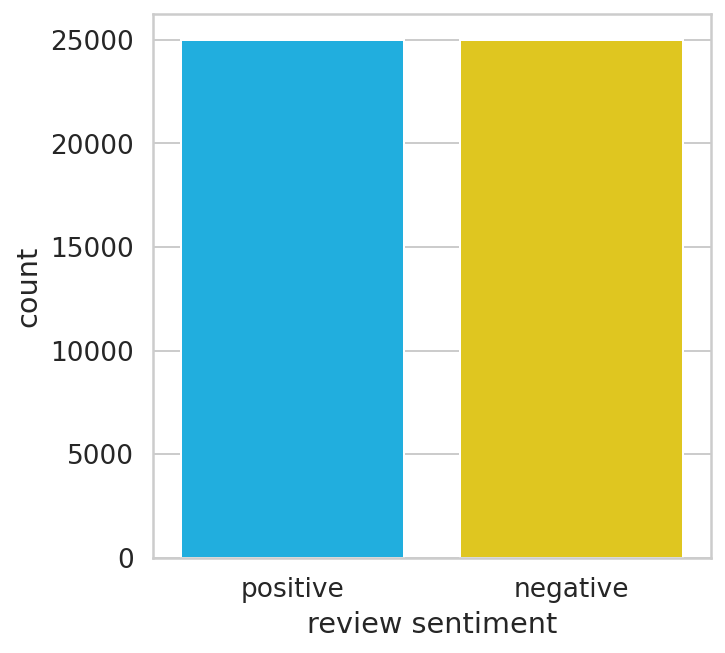

In [138]:
sns.countplot(df.sentiment)
plt.xlabel('review sentiment')

In [174]:
df['sentimentt'] = np.where(df['sentiment'] =='positive', 1, 0)

In [175]:
pd.set_option('max_colwidth', 100)

In [176]:
df.head()

,review,sentiment,sentimentt,len
0,One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked....,positive,1,1761
1,A wonderful little production. <br /><br />The filming technique is very unassuming- very old-ti...,positive,1,998
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air...",positive,1,926
3,Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his...,negative,0,748
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei off...",positive,1,1317


## Data Preprocessing

In [177]:
PRE_TRAINED_MODEL_NAME = "bert-base-cased"

In [179]:
tokenizer = transformers.BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [180]:
sample_txt = 'when was I last outside? I am stuck at home for 2 weeks.'

In [181]:
tokens = tokenizer.tokenize(sample_txt)
print(tokens)

['when', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']


In [183]:
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(sample_txt)
print(tokens)
print(token_ids)

when was I last outside? I am stuck at home for 2 weeks.
['when', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
[1165, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


## Special Tokens

In [184]:
print(f'Separation token - {tokenizer.sep_token, tokenizer.sep_token_id}')
print(f'Classification token - {tokenizer.cls_token, tokenizer.cls_token_id}')
print(f'Padding token - {tokenizer.pad_token, tokenizer.pad_token_id}')
print(f'Unknown token - {tokenizer.unk_token, tokenizer.unk_token_id}')

Separation token - ('[SEP]', 102)
Classification token - ('[CLS]', 101)
Padding token - ('[PAD]', 0)
Unknown token - ('[UNK]', 100)


In [185]:
encoding = tokenizer.encode_plus(
    sample_txt,
    max_length=32,
    add_special_tokens=True,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_token_type_ids=False,
    truncation=True,
    return_tensors='pt'
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [186]:
encoding['input_ids']

tensor([[ 101, 1165, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
         1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]])

In [187]:
len(encoding['input_ids'][0])

32

In [188]:
encoding['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

### Choosing Sequence Length

In [189]:
# token_lens = []

# for txt in df.review:
#   tokens = tokenizer.encode(txt, max_length=512, truncation=True)
#   token_lens.append(tokens)

In [190]:
# sns.distplot(token_lens)

In [191]:
df['len'] = df['review'].str.len()

In [192]:
df.head()

,review,sentiment,sentimentt,len
0,One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked....,positive,1,1761
1,A wonderful little production. <br /><br />The filming technique is very unassuming- very old-ti...,positive,1,998
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air...",positive,1,926
3,Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his...,negative,0,748
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei off...",positive,1,1317


In [193]:
df['len'].max()

13704

### Create a Dataset

In [194]:
class IMDBDataset(Dataset):
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      max_length=self.max_len,
      add_special_tokens=True,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_token_type_ids=False,
      truncation=True,
      return_tensors='pt'
)

    return {
        "review_text": review,
        "input_ids" : encoding["input_ids"].flatten(),
        "attention_mask" : encoding["attention_mask"].flatten(),
        "targets" : torch.tensor(target, dtype=torch.long)
    }

In [195]:
MAX_LEN = 160
BATCH_SIZE = 16
EPOCHS = 50

In [196]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_test, df_valid = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [197]:
print(df_train.shape)
print(df_test.shape)
print(df_valid.shape)

(40000, 4)
(5000, 4)
(5000, 4)


In [198]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = IMDBDataset(
      reviews=df.review.to_numpy(),
      targets=df.sentimentt.to_numpy(),
      tokenizer=tokenizer,
      max_len=max_len
  )

  return DataLoader(
      ds,
      batch_size=batch_size,
      num_workers=4
  )

In [199]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_valid, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [200]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [201]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


## Sentiment Classification with BERT and Hugging Face

In [202]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [203]:
last_hidden_state, pooled_output = bert_model(
    input_ids=encoding["input_ids"],
    attention_mask=encoding["attention_mask"]
)

In [204]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [205]:
pooled_output.shape

torch.Size([1, 768])

In [206]:
bert_model.config.hidden_size

768

In [210]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
        input_ids = input_ids,
        attention_mask = attention_mask
    )
    output = self.drop(pooled_output)
    output = self.out(output)
    return self.softmax(output)

In [208]:
class_names = ['negative', 'positive']

In [211]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [212]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape )
print(attention_mask.shape )

torch.Size([16, 160])
torch.Size([16, 160])


In [213]:
model(input_ids, attention_mask)

tensor([[0.5826, 0.4174],
        [0.5237, 0.4763],
        [0.4666, 0.5334],
        [0.5172, 0.4828],
        [0.5683, 0.4317],
        [0.6043, 0.3957],
        [0.6847, 0.3153],
        [0.5300, 0.4700],
        [0.5966, 0.4034],
        [0.7135, 0.2865],
        [0.3413, 0.6587],
        [0.5810, 0.4190],
        [0.7205, 0.2795],
        [0.6789, 0.3211],
        [0.6835, 0.3165],
        [0.6104, 0.3896]], grad_fn=<SoftmaxBackward>)

## Training

In [214]:
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [217]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()
  
  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d['input_ids'].to(device)
    attention_mask = d['attention_mask'].to(device)
    targets = d['targets'].to(device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [216]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_laoder:
      input_ids = d['input_ids'].to(device)
      attention_mask = d['attention_mask'].to(device)
      targets = d['targets'].to(device)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
  print(f'Epoch {epoch+1}/{EPOCHS}')
  print('*'*100)

  train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))
  print(f'Train loss{train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(model,valid_data_loader,loss_fn,device,len(df_val))
  print(f'Val   loss{val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['valid_acc'].append(valid_acc)
  history['valid_loss'].append(valid_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'model.pth')
    best_accuracy = val_acc

In [ ]:
# !gdown --id 

In [ ]:
model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load(''))
model = model.to(device)

In [ ]:
def get_reviews(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
  for d in data_laoder:
    texts = d['review_text']
    input_ids = d['input_ids'].to(device)
    attention_mask = d['attention_mask'].to(device)
    targets = d['targets'].to(device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    _, preds = torch.max(outputs, dim=1)

    review_texts.extend(texts)
    predictions.extend(preds)
    prediction_probs.extend(outputs)
    real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()

  return review_texts, predictions, prediction_probs, real_values

In [ ]:
  test_acc, test_loss = eval_model(model,test_data_loader,loss_fn,device,len(df_test))
  print(f'Test   loss{test_loss} accuracy {test_acc}')

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)